# Kernel Learning

Kernel learning is a way to transform features in either classification or regression problems. Recall in regression, we have the following model equation:

\begin{equation}
    \hat{y} = \vec{w}\vec{x} + b
\end{equation}

where $\vec{x}$ is our feature vector of dimension $D$. In kernel learning, we transform our feature vector from dimension $D$ features to *distances to training data points* of dimension $N$, where $N$ is the number of training data points:

\begin{equation}
    \hat{y} = \sum_i^N w_i \left<\vec{x}, \vec{x}_i\right>+ b
\end{equation}

where $\left<\cdot\right>$ is distance between two feature vectors and $\vec{x}_i$ is the $i$th training data point. $\vec{x}$ is the function argument whereas $\vec{x}_i$ are known values. 

```{margin}
Although we will use the word distance, the $\left<\cdot\right>$ function is actually an inner product which is more flexible than a distance.
```

One of the consequences of this transformation is that our training weight vector, $\vec{w}$, no longer depends on the number of features. **Instead the number of weights depends on the number of training data points.** This is the reason we use kernel learning. You might have few training data points but large feature vectors ($N < D$). By using the kernel formulation, you'll reduce the numbe of weights. It might also be that your feature space is hard to model with a linear equation, but when you view it as distances from training data it becomes linear (often $N > D$). Finally, it could be that your feature vector is infinite dimensional (i.e., it is a function not a vector) or for some reason you cannot compute it. In kernel learning, you only need to define your *kernel function*  $\left<\cdot\right>$ and never explicitly work with the feature vector. 

The distance function is called a *kernel function*  $\left<\cdot\right>$. A kernel function is a binary function (takes two arguments) that outputs a scalar and has the following properties:

1. Positive: $\left<x, x'\right> \geq 0$
2. Symmetric: $\left<x, x'\right> = \left<x', x \right>$
3. Point-separating: $\left<x, x'\right> = 0$ if and only if $x = x'$

The classic kernel function example is $l_2$ norm (Euclidean distance): $\left<\vec{x}, \vec{x}'\right>=\sqrt{\sum^D_i (x_i - x_i^{'})^2}$. Some of the most interesting applications of kernel learning though are when $x$ is not a vector, but a function or some other structured object. 

```{admonition} Primal & Dual Form
:class: tip
**Dual Form** is what some call our model equation when it uses the kernels: $\hat{y} = \sum_i^N w_i \left<\vec{x}, \vec{x}_i\right>+ b$. To distinguish from the dual form, you can also refer to the usual model equation as the **Primal Form**  $\hat{y} = \vec{w}\vec{x} + b$. It also sounds cool. 
```

Kernel learning is a widely-used approach for learning potential energy functions and force fields in molecular modeling {cite}`scherer2020kernel,rupp2012fast`

## Solubility Example

Let's revisit the solubility AqSolDB{cite}`Sorkun2019` dataset from {doc}`regression`. Recall it has about 10,000 unique compounds with measured solubility in water (label) and 17 molecular descriptors (features).

### Running This Notebook


Click the &nbsp;<i aria-label="Launch interactive content" class="fas fa-rocket"></i>&nbsp; above to launch this page as an interactive Google Colab. See details below on installing packages, either on your own environment or on Google Colab

````{tip} My title
:class: dropdown
To install packages, execute this code in a new cell

```
!pip install jupyter-book matplotlib numpy jaxlib jax pandas seaborn tabulate
```

````

As usual, the code below sets-up our imports.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import jax.numpy as jnp
import jax.experimental.optimizers as optimizers
import jax
import warnings
warnings.filterwarnings('ignore')
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
soldata = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/3407241?format=original&gbrecs=true')
features_start_at = list(soldata.columns).index('MolWt')
feature_names = soldata.columns[features_start_at:]
np.random.seed(0)

# standardize the features
soldata[feature_names] -= soldata[feature_names].mean()
soldata[feature_names] /= soldata[feature_names].std()

## Kernel Definition

We'll start by creating our kernel function. *Our kernel function does not need to be differentiable*. In constrast to the functions we see in deep learning, we can use sophisticated and non-differentiable functions in kernel learning. For example, you could use a binary molecular dynamics simulation to compute the kernel between two molecules.  We'll still implement our kernel functions in JAX for this example because it is efficient and consistent. Remember our kernel should take two feature vectors and return a scalar. In our example, we will simply use the $l_2$ norm. I will add one small twist though: dividing by the dimension. This makes it so that our kernel output magnitude is independent of the number of dimensions of $x$. 

In [204]:
def kernel(x1, x2):
    return jnp.sqrt(jnp.mean((x1 - x2)**2))

## Model Definition


```{margin}
Since we're doing linear regression, you can compute the fit coefficients by just doing matrix algebra. We'll still approach this problem with gradient descent even though there are more efficient model-specific procedures.
```

Now we define our regression model equation in the *dual form*. Remember that our function must always take the training data in to compute the distance to a new given point. We will use the batch feature of JAX to compute all the kernels simultaneously for our new point.


In [205]:
def model(x, train_x, w, b):
    # make vectorized version of kernel
    vkernel = jax.vmap(kernel, in_axes=(None, 0), out_axes=0)
    # compute kernel with all training data
    s = vkernel(x, train_x)
    # dual form
    yhat = jnp.dot(s,w) + b
    return yhat
# make batched version that can handle multiple xs
batch_model = jax.vmap(model, in_axes=(0, None, None, None), out_axes=0)

## Training

We now have trainable weights and a model equation. To begin training, we need to define a loss function and compute its gradient. We'll use mean squared error as usual for the loss function. We can use regularization, as we saw previously, but will skip it for now. 

In [206]:
@jax.jit
def loss(w, b, train_x, x, y):
    return jnp.mean( (batch_model(x, train_x, w, b) - y)**2)
loss_grad = jax.grad(loss, (0,1))


# Get 80/20 split
N = len(soldata)
train = soldata[:int(N * 0.8)]
test = soldata[int(N * 0.8):]

# convert from pandas dataframe to numpy arrays
train_x = train[feature_names].values
train_y = train['Solubility'].values
test_x = test[feature_names].values
test_y = test['Solubility'].values


We've defined our loss and split our data into training/testing. Now we will set-up the training parameters, including breaking up our training data into batches.

In [232]:
eta = 1e-5
batch_size = 32
epochs = 10


# reshape into batches
batch_num = train_x.shape[0] // batch_size
# first truncate data so it's whole nubmer of batches
trunc = batch_num * batch_size
train_x = train_x[:trunc]
train_y = train_y[:trunc]
# split into batches
x_batches = train_x.reshape(-1, batch_size, train_x.shape[-1])
y_batches = train_y.reshape(-1, batch_size)


# make trainable parameters
#w = np.random.normal(scale = 1e-30, size=train_x.shape[0])
w = np.zeros(train_x.shape[0])
b = np.mean(train_y) # just set to mean, since it's a good first guess
      

You may notice our learning rate, $\eta$, is unusually low at $10^{-5}$. It's because each training data point, for which we have about 8,000, contributes to the final $\hat{y}$. Thus if we take a large training step, it is can create very big changes to $\hat{y}$. 

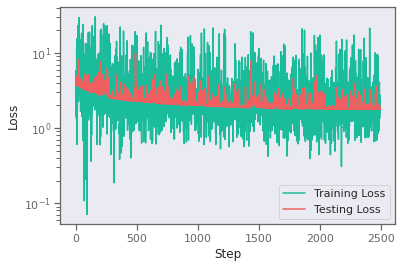

In [233]:
   
loss_progress = []
test_loss_progress = []

for _ in range(epochs):
    # go in random order
    for i in np.random.random_integers(0, batch_num - 1, size=batch_num):    
        # update step
        x = x_batches[i]
        y = y_batches[i]
        loss_progress.append(loss(w, b, train_x, x, y))
        test_loss_progress.append(loss(w, b, train_x, test_x, test_y))
        grad = loss_grad(w, b, train_x, x, y)    
        w -= eta * grad[0]
        b -= eta * grad[1]
plt.plot(loss_progress, label='Training Loss')
plt.plot(test_loss_progress, label='Testing Loss')

plt.xlabel('Step')
plt.yscale('log')
plt.legend()
plt.ylabel('Loss')
plt.show()

One small change from previous training loops is that we randomized our batches in the `for` loop.

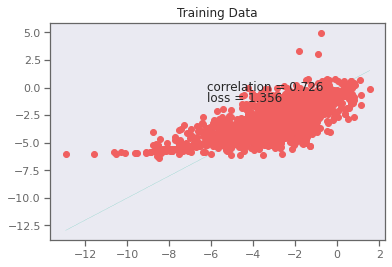

In [234]:
yhat = batch_model(test_x, train_x, w, b)
plt.plot(test_y, test_y, ':', linewidth=0.2)
plt.plot(test_y, yhat, 'o')
plt.text(min(y) + 1, max(y) - 2, f'correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}')
plt.text(min(y) + 1, max(y) - 3, f'loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}')
plt.title('Testing Data')
plt.show()

We can see our results show underfitting. As usual, I want to make this code execute fast so I have not done many epochs. You can increase the epoch number and watch the loss and correlation improve over time. 

## Regularization


You'll notice that our trainable parameter number, by design, is equal to the number training data points. If we were to use a direct computation of the fit coefficients with a pseudo-inverse, we could run into problems because of this. Thus, most people add an additional regularization term to both make matrix algebra solutions tractable and because it seems wise with the large number of trainable parameters. Just like we saw in linear regression, L1 regression is known as **Lasso Ridge Regression** and L2 is known as **Kernel Ridge Regression**. Remember that L1 zeros-out specific parameters which was useful for interpreting the importance of features in linear regression. However, in the kernel setting this would only zero-out specific training data points and thus provides no real insight(usually, see {doc}`../dl/xai`). Kernel ridge regression is thus more popular in the kernel setting.

## Training Curves

The bias-variance trade-off from {doc}`../ml/regression` showed how increasing model complexity could reduce model bias (more expressive and able to fit data better) at the cost of increased model variance (more sensitive to training data choice and amount). The model complexity was controlled by adjusting feature number. In kernel learning, we cannot control feature number because it is always equal to the number of training data points. Thus, we can only control hyperparameters like the choice of kernel, regularization, learning rate, etc. To assess these effects, we usually do not only compute test loss because that is highly-connected to the amount of training data you have. More training data means more sophisticated models and thus lower loss. So it is common in kernel learning especially to show how the test-loss changes a function of training data amount. These are presented as log-log plots due to the large magnitude changes in these. These are called **training curves**. Training curves can be applied broadly in ML and deep learning, but you'll most often see them in kernel learning.

Let's revisit our solubility model and compare L1 and L2 regularization with a training curve. Note that this code is very slow because we must compute $M$ models, where $M$ is the number of points we want on our training curve. To keep things efficient for this textbook, I'll use few points on the curve.

First, we'll turn our training procedure into a function.

In [235]:
def fit_model(loss, npoints, eta=1e-6, batch_size=16, epochs=25):
    
    sample_idx = np.random.choice(np.arange(train_x.shape[0]), replace=False, size=npoints)
    sample_x = train_x[sample_idx, :]
    sample_y = train_y[sample_idx]
        
    # reshape into batches
    batch_num = npoints // batch_size
    # first truncate data so it's whole nubmer of batches
    trunc = batch_num * batch_size
    sample_x = sample_x[:trunc]
    sample_y = sample_y[:trunc]
    # split into batches
    x_batches = sample_x.reshape(-1, batch_size, sample_x.shape[-1])
    y_batches = sample_y.reshape(-1, batch_size)


    # get loss grad
    loss_grad = jax.grad(loss, (0,1))
    
    # make trainable parameters
    #w = np.random.normal(scale = 1e-30, size=train_x.shape[0])
    w = np.zeros(sample_x.shape[0])
    b = np.mean(sample_y) # just set to mean, since it's a good first guess
    for _ in range(epochs):
        # go in random order
        for i in np.random.random_integers(0, batch_num - 1, size=batch_num):    
            # update step
            x = x_batches[i]
            y = y_batches[i]
            grad = loss_grad(w, b, sample_x, x, y)    
            w -= eta * grad[0]
            b -= eta * grad[1]
    return loss(w, b, sample_x, test_x, test_y)

# test it out
fit_model(loss, 256)

DeviceArray(3.8370183, dtype=float32)

Now we'll create L1 and L2 version of our loss. We must choose the *strength* of the regularization. Since our weights are less than 1, I'll choose much stronger regularization for the L2. These are hyperparameters though and you can adjust them to improve your fit. 

In [236]:
@jax.jit
def loss_l1(w, b, train_x, x, y):
    return jnp.mean( (batch_model(x, train_x, w, b) - y)**2) + 1e-2 * jnp.sum(jnp.abs(w))

@jax.jit
def loss_l2(w, b, train_x, x, y):
    return jnp.mean( (batch_model(x, train_x, w, b) - y)**2) + 1e2 * jnp.sum(w**2)

And now we can generate the points necessary for our curves!

In [237]:
nvalues = [32, 256, 512, 1024, 2048, 1024 * 5]

nor_losses = [fit_model(loss, n) for n in nvalues]
l1_losses = [fit_model(loss_l1, n) for n in nvalues]
l2_losses = [fit_model(loss_l2, n) for n in nvalues]

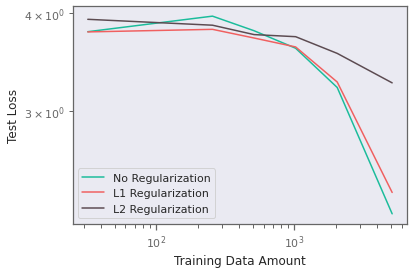

In [238]:
plt.plot(nvalues, nor_losses, label='No Regularization')
plt.plot(nvalues, l1_losses, label='L1 Regularization')
plt.plot(nvalues, l2_losses, label='L2 Regularization')
plt.legend()
plt.xlabel('Training Data Amount')
plt.ylabel('Test Loss')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')


Finally, we see our training curves showing the different approaches. Regularization has some effect on final loss on the test data. It is hard to say if L1 and L2 are simply worse, or if I need to tune the regularization strength more. Nevertheless, this plot shows you how we typically evaluated kernel learning methods. 

## Exercises

1. Compute the analytical gradient for the dual form regression equation and use it to describe why the kernel function does not need to be differentiable.
2. Is it faster or slower to do training with kernel learning? Explain
3. Is it faster or slower to do inference with kernel learning? Explain
4. How can we modify Equation 4.2 to do classification? 
5. Do the weight values give relative importance of training examples regardless of kernel?
6. Create a training curve from the above example showing 5 different L1 regularization strengths. Why might regularization not matter here?

## Chapter Summary

* In this section we introduced kernel learning, which is a method to transform features into distance between samples.
* A kernel function takes two arguments and outputs a scalar. It has three properties: positive, symmetric, and point-separating.
* The distance function (inner product) is a kernel function.
* Kernel functions do not need to be differentiable.
* The number of trainable parameters in a kernel model is proportional to number of training points, not dimension of features.

## Cited References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```